In [2]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
"""
Enables GPU for faster training
"""

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
"""
Defines a custom dataset in order to implement pytorch's built in model capabilities
"""

class RoverDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, sep=";")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data["Path"][idx]
        index = img_name.find("robocam")
        local_path = "/home/exouser/IMG/" + img_name[index:]
        
        try:
            image = Image.open(local_path)
        except FileNotFoundError:
            return self.__getitem__((idx + 1) % len(self))

        steering_angle = float(self.data["SteerAngle"][idx])
        throttle = float(self.data["Throttle"][idx])
        
        steering_angle_tensor = torch.tensor(steering_angle, dtype=torch.float32)
        throttle_tensor = torch.tensor(throttle, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'SteerAngle': steering_angle, 'Throttle': throttle}
        

In [5]:
"""
Defines a transformation of the collected images. The mean and std are commonly used image normalization values but can be experimented with.
"""

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize(            
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
def get_subsample(num_samples, sample_dataset):
    
    all_indices = list(range(len(sample_dataset)))

    random_indices = random.sample(all_indices, num_samples)

    random_samples = [sample_dataset[idx] for idx in random_indices]
    
    return random_samples

In [26]:
def run_model(sample_dataset, model, optimizer):    
    """
    Split dataset into 90% train and 10% test
    """

    train_size = int(0.9 * len(sample_dataset))
    test_size = len(sample_dataset) - train_size
    train_set, test_set = random_split(sample_dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

    """
    num_features = model.fc.in_features  
    model.fc = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128, 2)  # 2 output neurons for two numerical values
    )
    
    """
    model.fc = nn.Linear(model.fc.in_features, 2)

    """
    Opted to do a regression model. Both the loss function and optimizer would be good hyperparameters to experiment with
    """

    criterion = nn.MSELoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    """
    The model is trained on about 1500 images which is somewhat small. Didn't use a large number of epochs since the resnet model is pretrained.
    """

    model.to(device)

    train_losses = []
    test_losses = []

    for param in model.parameters():
        param.to(device)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        #print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)
                outputs = model(images)
                loss = criterion(outputs, targets.float())
                test_loss += loss.item() * images.size(0)
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        #print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")

    graph_loss(train_losses, test_losses, num_epochs)

In [8]:
def graph_loss(train_losses, test_losses, num_epochs):
    axis = list(range(1,num_epochs + 1))
    fig, ax = plt.subplots()

    a, = ax.plot(axis, train_losses)
    b, = ax.plot(axis, test_losses)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend((a, b), ('Train Loss', 'Test Loss'), loc='upper right', shadow=True)

    plt.show()

In [9]:
sample_dataset = RoverDataset(csv_file="/home/exouser/robot_log.csv", root_dir="/home/exouser/IMG", transform=transform)

In [10]:
#Examine image size

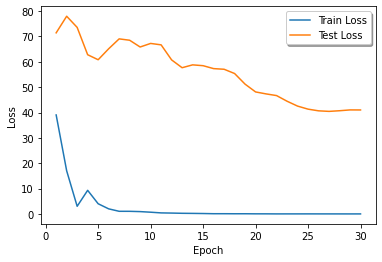

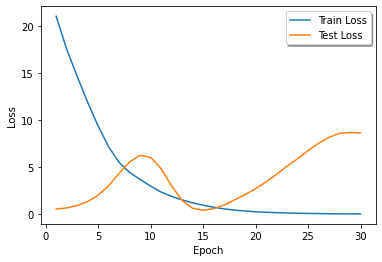

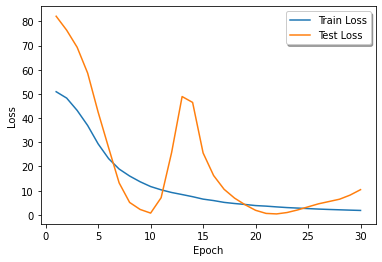

In [27]:
sample_19000 = get_subsample(19, sample_dataset)
sample_8000 = get_subsample(8, sample_dataset)
sample_2000 = get_subsample(8, sample_dataset)

model = models.resnet18(pretrained=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)

run_model(sample_19000, model, optimizer)
run_model(sample_8000, model, optimizer)
run_model(sample_2000, model, optimizer)

In [ ]:
#Examine models

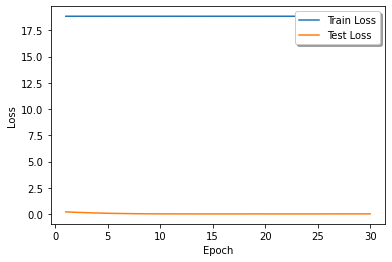

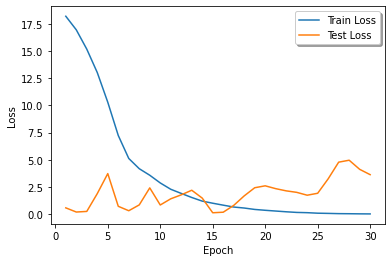

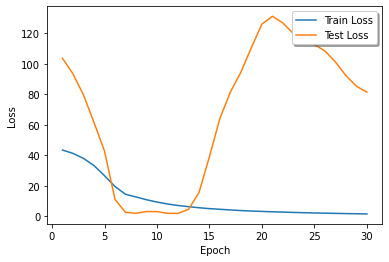

In [28]:
sample = sample_8000
model_alexnet = models.resnet18(pretrained=True)
model_resnet18 = models.resnet50(pretrained=True)
model_resnet50 = models.resnet101(pretrained=True)

run_model(sample, model_alexnet, optimizer)
run_model(sample_8000, model, optimizer)
run_model(sample_2000, model, optimizer)

In [ ]:
#Examine optimizers

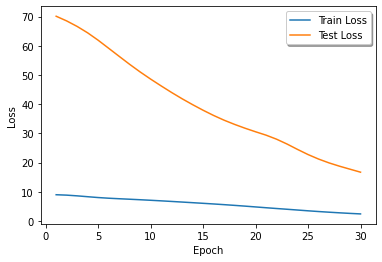

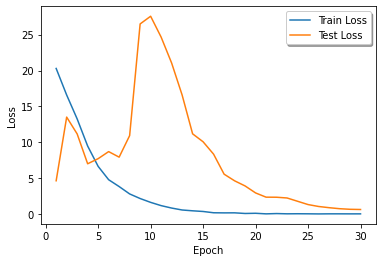

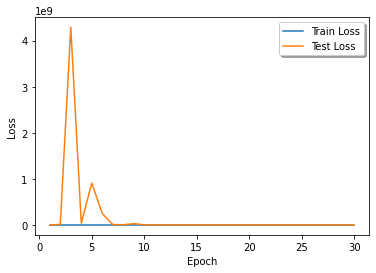

In [29]:
optimizer_SGD = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer_Adam = optim.Adam(model.parameters(), lr=0.001)
optimizer_RMSprop = optim.RMSprop(model.parameters(), lr=0.001)

run_model(sample, model, optimizer_SGD)
run_model(sample, model, optimizer_Adam)
run_model(sample, model, optimizer_RMSprop)
